# **1.  Embedding CNN Model for Sentiment Analysis**

## 1.1. Define Vocab

In [6]:
import string
import re 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from os import listdir
from collections import Counter
from nltk.corpus import stopwords

# 1. load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all the text
  text = file.read()
  # close the file
  file.close()
  return text

# 2. turn doc into clean tokens
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word)>1]
  return tokens

# 3. load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
  # load doc
  doc = load_doc(filename)
  # clean doc
  tokens = clean_doc(doc)
  # update counts
  vocab.update(tokens)

# 4. load all docs in a directory
def process_doc(directory, vocab):
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # add doc to vocab
    add_doc_to_vocab(path, vocab)

# 4. Save list to files

def save_list(lines, filename):
  # conver lines to a single blob of text
  data = '\n'.join(lines)
  # open file
  file = open(filename, 'w')
  # write text
  file.write(data)
  # close file
  file.close()

# define vocab
vocab = Counter()
# add all docs to vocab
process_docs("/content/drive/MyDrive/Dataset/review_polarity/txt_sentoken/neg", vocab)
process_docs("/content/drive/MyDrive/Dataset/review_polarity/txt_sentoken/pos", vocab)
# print the size of the vocab 
print(len(vocab))
# keep tokens with a min occurrence
min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane] 
print(len(tokens))
# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
44276
25767


## 1.2. Train CNN With Embedding Layer

In [ ]:
import string
import re
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import numpy as np

# Func 1: load doc into memory
def load_doc(filename):
  # open file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

# Func 2: turn doc into tokens
def clean_doc(doc, vocab):
  # split into tokens by white spance
  tokens = doc.split()
  # reparare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # filter out tokens not in vocab
  tokens = [word for word in tokens if word in vocab]
  tokens = ' '.join(tokens)
  return tokens


# Func 3: load all docs in directory
def process_docs(directory, vocab, is_train):
  documents = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # load the doc
    doc = load_doc(path)
    # clean doc
    tokens = clean_doc(doc, vocab)
    # add to list
    documents.append(tokens)
  return documents

# Func 4: load and clean dataset
def load_clean_dataset(vocab, istrain):
  # load documents
  neg = process_docs("/content/drive/MyDrive/Dataset/review_polarity/txt_sentoken/neg", vocab, istrain)
  pos = process_docs("/content/drive/MyDrive/Dataset/review_polarity/txt_sentoken/pos", vocab, istrain)
  docs = neg + pos
  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
  labels = np.array(labels)
  return docs, labels

# Func 5: fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [7]:
import string
import re
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import numpy as np


# Func 1: load doc into memory
def load_doc(filename):
  # open file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

# Func 2: turn doc into tokens
def clean_doc(doc, vocab):
  # split into tokens by white spance
  tokens = doc.split()
  # reparare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # filter out tokens not in vocab
  tokens = [word for word in tokens if word in vocab]
  tokens = ' '.join(tokens)
  return tokens


# Func 3: load all docs in directory
def process_docs(directory, vocab, is_train):
  documents = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # load the doc
    doc = load_doc(path)
    # clean doc
    tokens = clean_doc(doc, vocab)
    # add to list
    documents.append(tokens)
  return documents

# Func 4: load and clean dataset
def load_clean_dataset(vocab, istrain):
  # load documents
  neg = process_docs("/content/drive/MyDrive/Dataset/review_polarity/txt_sentoken/neg", vocab, istrain)
  pos = process_docs("/content/drive/MyDrive/Dataset/review_polarity/txt_sentoken/pos", vocab, istrain)
  docs = neg + pos
  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
  labels = np.array(labels)
  return docs, labels

# Func 5: fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

# Func 6: integer encode and pad documents
def encode_docs(tokenizer, max_length, docs):
  # integer encode
  encoded = tokenizer.texts_to_sequences(docs)
  # pad sequences
  padded = pad_sequences(encoded, maxlen = max_length, padding = 'post')
  return padded

# Func 7: define model
def define_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 100, input_length = max_length))
  model.add(Conv1D(filters = 32, kernel_size = 8, activation = 'relu'))
  model.add(MaxPooling1D(pool_size = 2))
  model.add(Flatten())
  model.add(Dense(10, activation = 'relu'))
  model.add(Dense(1, activation = 'sigmoid'))
  # compile network
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  # summarize defined model
  model.summary()
  plot_model(model, to_file = 'model.png', show_shapes = True)
  return model

# 8. Apply

# load vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

# load training data
train_docs, ytrain = load_clean_dataset(vocab, True)
# create the tokenizer
tokenizer = create_tokenizer(train_docs)
# define vocabulary size
vocab_size = len(tokenizer.word_index)+1
print('Vocabulary size: %d' % vocab_size)

# calculate the maximum sequence length
max_length = max([len(s.split())for s in train_docs])
print('Maximum length: %d' % max_length)

# encode data
Xtrain = encode_docs(tokenizer, max_length, train_docs)
# define model
model =  define_model(vocab_size, max_length)
# fit network
model.fit(Xtrain, ytrain, epochs = 10, verbose =2)
# save the model
model.save('model.h5')

Vocabulary size: 25768
Maximum length: 1317
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1317, 100)         2576800   
_________________________________________________________________
conv1d (Conv1D)              (None, 1310, 32)          25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 655, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 20960)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                209610    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,812,053
Trainable params: 2,812,053
Non-trainable params: 0
__

## 1.3. Evaluate model

In [ ]:
from keras.models import load_model
# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
# create the tokenizer
tokenizer = create_tokenizer(train_docs)
# define vocabulary size
vocab_size = len(tokenizer.word_index)+1
print('Vocabulary size: %d' % vocab_size)
# calculate the maximum sequence length
max_length = max([len(s.split())for s in train_docs])
print('Maximum length: %d' % max_length)
# encode data
Xtrain = encode_docs(tokenizer, max_length, train_docs)
Xtest = encode_docs(tokenizer, max_length, test_docs)

# load model
model = load_model('model.h5')
# evaluate model on training dataset
_, acc = model.evaluate(Xtrain, ytrain, verbose = 0)
print('Train Accuracy: %f' % (acc*100))

# evaluate model on test dataset
_, acc = model.evaluate(Xtest, ytest, verbose = 0)
print('Test Accuracy: %f' % (acc*100))

Vocabulary size: 25768
Maximum length: 1317
Train Accuracy: 100.000000
Test Accuracy: 86.500001


In [ ]:
# classify a review as negative or possitive
def predict_sentiment(review, vocab, tokenizer, max_length, model):
  # clean review
  line = clean_doc(review, vocab)
  # encode and pad review
  padded = encode_docs(tokenizer, max_length, [line])
  # predict sentiment
  yhat = model.predict(padded, verbose = 0)
  # retrieve predicted percentage and label
  percent_pos = yhat[0,0]
  if round(percent_pos) ==0:
    return (1-percent_pos), 'NEGATIVE'
  return percent_pos, 'POSITIVE'


# test positive text
text = 'Everyone will enjoy this film. I love it, recommended!'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model) 
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
# test negative text
text = 'This is a bad movie. Do not watch it. It sucks.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, max_length, model) 
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [Everyone will enjoy this film. I love it, recommended!]
Sentiment: NEGATIVE (72.918%)
Review: [This is a bad movie. Do not watch it. It sucks.]
Sentiment: NEGATIVE (76.526%)


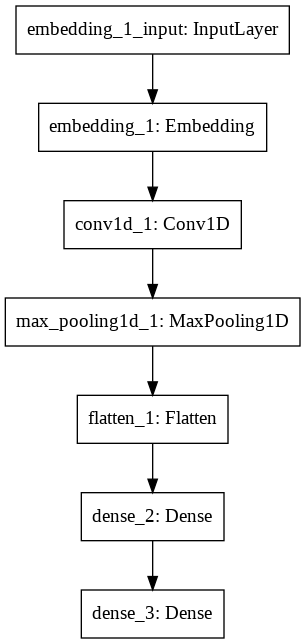

In [ ]:
plot_model(model)

# **2. n-gram CNN Model for Sentiment Analysis**

## 2.1. Data preparation

In [ ]:
import string
import re
from os import listdir
from nltk.corpus import stopwords
from pickle import dump

# 1. load doc into memory
def load_doc(filename):
  # open the file as read only 
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file file.close()
  return text

# 2. turn a doc into clean tokens
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation)) 
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  tokens = ' '.join(tokens)
  return tokens

# 3. load all docs in a directory
def process_docs(directory, is_train):
  documents = list()
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip any reviews in the test set
    if is_train and filename.startswith('cv9'): 
      continue
    if not is_train and not filename.startswith('cv9'): 
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # load the doc
    doc = load_doc(path)
    # clean doc
    tokens = clean_doc(doc)
    # add to list
    documents.append(tokens)
  return documents

# 4. load and clean a dataset
def load_clean_dataset(is_train):
  # load documents
  neg = process_docs("/content/drive/MyDrive/Dataset/review_polarity/txt_sentoken/neg",  is_train)
  pos = process_docs("/content/drive/MyDrive/Dataset/review_polarity/txt_sentoken/pos",  is_train)
  docs = neg + pos
  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))] 
  return docs, labels

# 5. save a dataset to file
def save_dataset(dataset, filename): 
  dump(dataset, open(filename, 'wb')) 
  print('Saved: %s' % filename)

# load and clean all reviews
train_docs, ytrain = load_clean_dataset(True) 
test_docs, ytest = load_clean_dataset(False)
# save training datasets 
save_dataset([train_docs, ytrain], 'train.pkl') 
save_dataset([test_docs, ytest], 'test.pkl')

Saved: train.pkl
Saved: test.pkl


## 2.2. Develop Multichannel Model

In [ ]:
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
import numpy as np 

# load a clean dataset
def load_dataset(filename):
  return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

# calculate the maximum document length
def max_length(lines):
  return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
  # integer encode
  encoded = tokenizer.texts_to_sequences(lines)
  # pad encoded sequences
  padded = pad_sequences(encoded, maxlen=length, padding='post') 
  return padded

# define the model
def define_model(length, vocab_size):
  # channel 1
  inputs1 = Input(shape=(length,))
  embedding1 = Embedding(vocab_size, 100)(inputs1)
  conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1) 
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)
  # channel 2
  inputs2 = Input(shape=(length,))
  embedding2 = Embedding(vocab_size, 100)(inputs2)
  conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2) 
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)
  # channel 3
  inputs3 = Input(shape=(length,))
  embedding3 = Embedding(vocab_size, 100)(inputs3)
  conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3) 
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)
  # merge
  merged = concatenate([flat1, flat2, flat3])
  # interpretation
  dense1 = Dense(10, activation='relu')(merged)
  outputs = Dense(1, activation='sigmoid')(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  # compile
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
  # summarize
  model.summary()
  plot_model(model, show_shapes=True, to_file='model.png')
  return model

# load training dataset
trainLines, trainLabels = load_dataset('train.pkl') 
# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
print('Max document length: %d' % length)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
# define model
model = define_model(length, vocab_size)
# fit model
model.fit([trainX,trainX,trainX], np.array(trainLabels), epochs=7, batch_size=16) 
# save the model
model.save('model.h5')

Max document length: 1380
Vocabulary size: 44277
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1380)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1380)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1380)]       0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1380, 100)    4427700     input_4[0][0]                    
___________________________________________

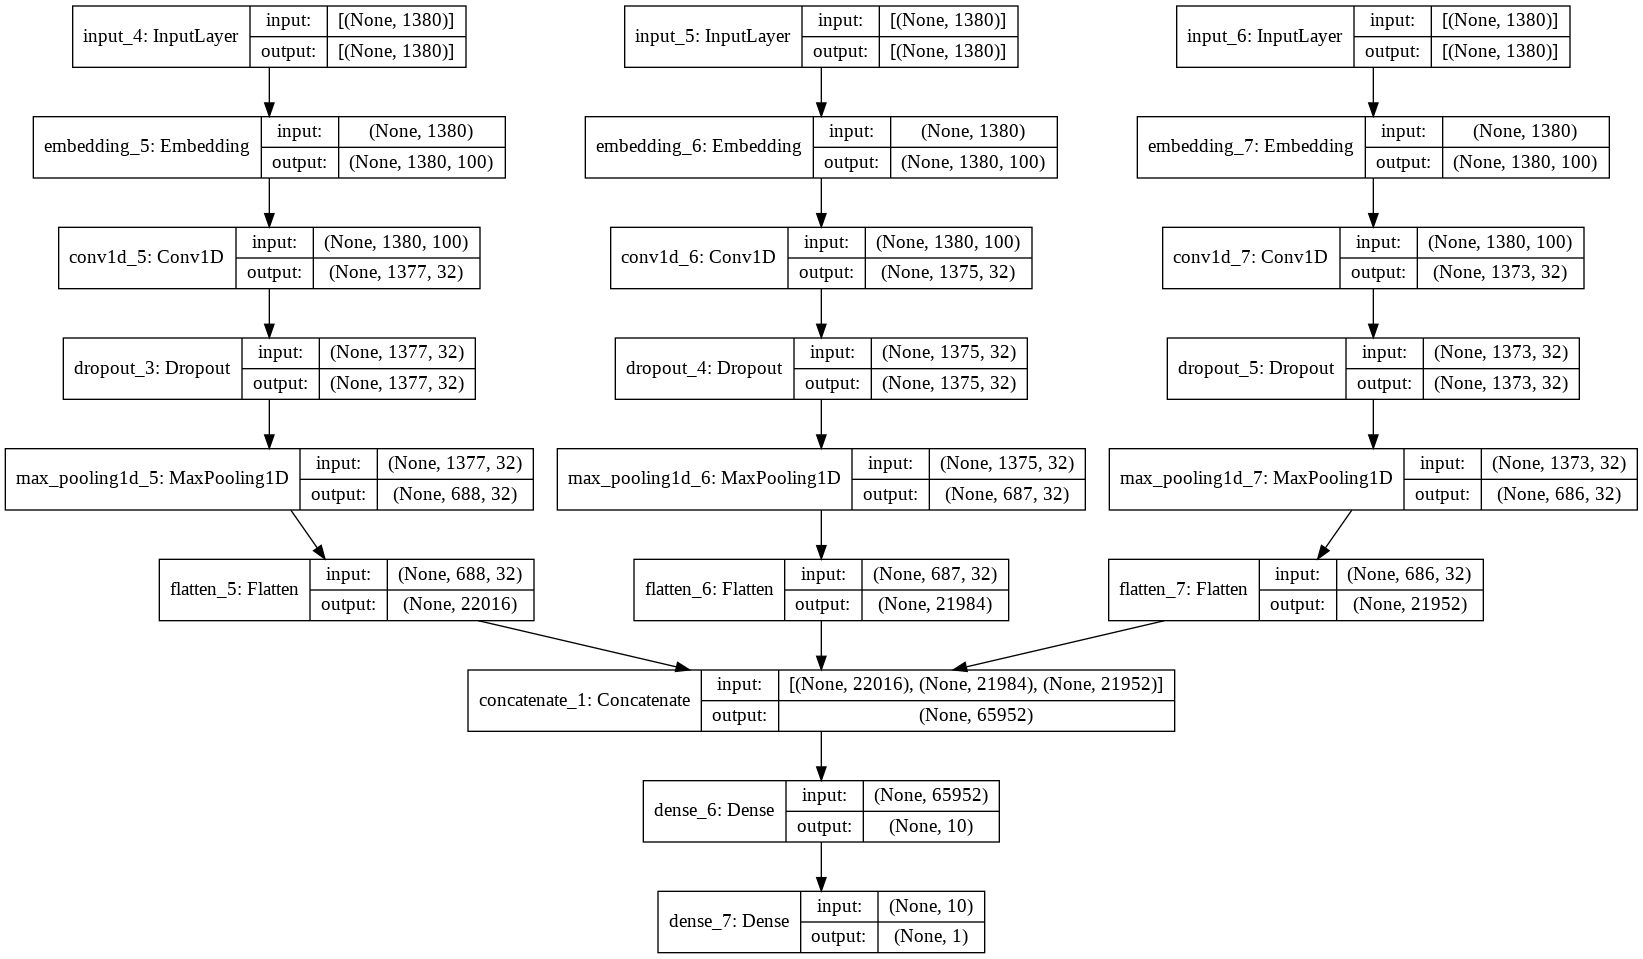

In [ ]:
plot_model(model, show_shapes=True, to_file='model.png')

## 2.3. Evaluate mode

In [ ]:
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
# load a clean dataset
def load_dataset(filename):
  return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

# calculate the maximum document length
def max_length(lines):
  return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
  # integer encode
  encoded = tokenizer.texts_to_sequences(lines)
  # pad encoded sequences
  padded = pad_sequences(encoded, maxlen=length, padding='post') 
  return padded

# load datasets
trainLines, trainLabels = load_dataset('train.pkl') 
testLines, testLabels = load_dataset('test.pkl')
# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
print('Max document length: %d' % length)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
testX = encode_text(tokenizer, testLines, length)
# load the model
model = load_model('model.h5')
# evaluate model on training dataset
_, acc = model.evaluate([trainX,trainX,trainX], np.array(trainLabels), verbose=0) 
print('Train Accuracy: %.2f' % (acc*100))
# evaluate model on test dataset dataset
_, acc = model.evaluate([testX,testX,testX], np.array(testLabels), verbose=0) 
print('Test Accuracy: %.2f' % (acc*100))

Max document length: 1380
Vocabulary size: 44277
Train Accuracy: 100.00
Test Accuracy: 84.50
